In [2]:
from model.MVANet_recon_1024 import MVANet_plus
from model.hvae.HVAE import HierarchicalVAE, hvae_cfg

import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

/home/ub/anaconda3/envs/icmil/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ub/anaconda3/envs/icmil/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def load_image(img_path, device):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((2048, 2048))
    transform = T.Compose([
        T.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor, img

def tensor_to_image(t):
    t = t.squeeze().detach().cpu().numpy()
    t = np.clip(t, 0, 1)
    t = np.transpose(t, (1, 2, 0)) 
    return t

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_path ='../../Model_93024_loss_0.1249.pth'
image_name = os.path.splitext(os.path.basename(image_path))[0]


hvae_cfg_ = hvae_cfg() 
model = MVANet_plus(hvae_cfg=hvae_cfg_, hvae_path='../../best.pt').to(device)
model.eval()
model.load_state_dict(torch.load(weight_path, map_location=device), strict=True)

<All keys matched successfully>

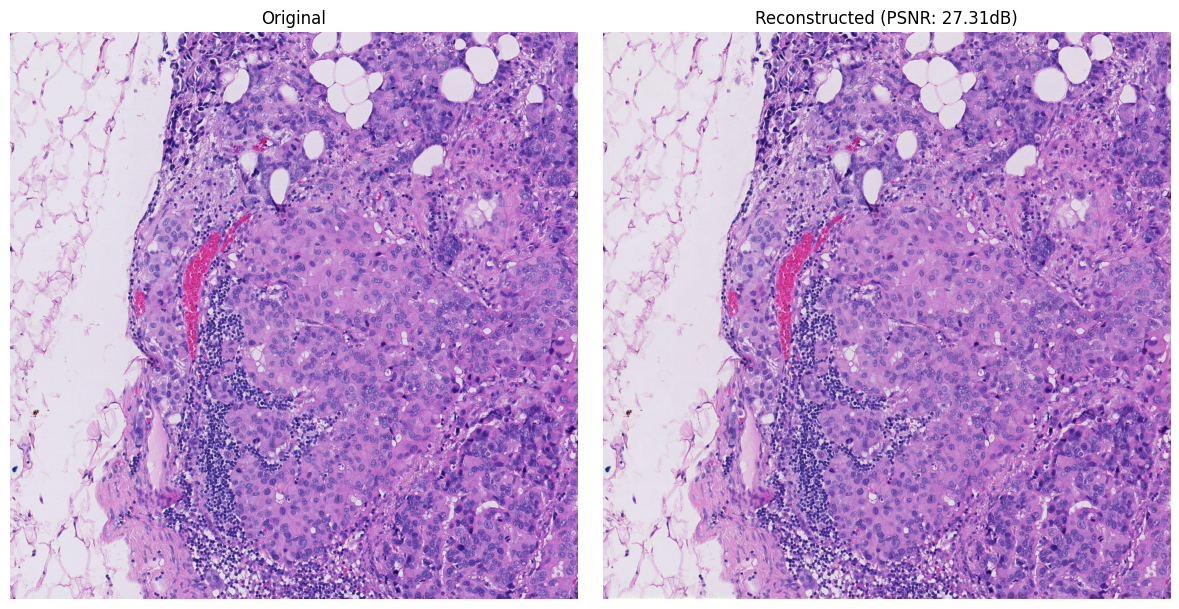

<Figure size 640x480 with 0 Axes>

In [11]:
image_path = 'c16_fig_recon_test/test_001/14400_13952.jpg' 
img_tensor, original_img = load_image(image_path, device)

with torch.no_grad():
    output = model(img_tensor, image_name) 
    output_img = tensor_to_image(output)

original_np = np.array(original_img.resize((2048, 2048))) / 255.0

p = psnr(original_np, output_img)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_np)
axs[0].set_title('Original')
axs[1].imshow(output_img)
axs[1].set_title(f'Reconstructed (PSNR: {p:.2f}dB)')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()
plt.savefig("2.jpg",dpi=600)